In [1]:
# imports 

import tensorflow as tf
import os 
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Flatten, Dense, LSTM, TimeDistributed, Input, Concatenate
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, TimeDistributed, LSTM, Dense, Concatenate, RepeatVector, Reshape, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

In [66]:
# specify your directory where files are located 
# tensors loading

files_dir = '../data/processed/'
loaded_tensors = dict()
for file in [x for x in os.listdir(files_dir) if x.endswith("tfrecord")]:
    serialized_tensor = tf.io.read_file(os.path.join(files_dir,file))
    loaded_tensors[file] = tf.io.parse_tensor(serialized_tensor, out_type=tf.float32)

# coordinates loading 
df_coords = pd.read_excel(os.path.join(files_dir,"Coordinates_processed.xlsx"),sheet_name=['X','Y','TVD1','TVD2'],header=None)
df_X_Y = pd.DataFrame({col: list(zip(df_coords["X"][col], df_coords["Y"][col])) for col in  df_coords["X"].columns})
df_TVD = pd.DataFrame({col: list(zip(df_coords["TVD1"][col], df_coords["TVD2"][col])) for col in  df_coords["TVD1"].columns})

# time loading 
time_sequence = pd.read_csv(os.path.join(files_dir,"Dates_processed.csv"))

### Пример кода преобразования

In [34]:
import numpy as np

# Initial matrix values
matrix_values = [
    ['p22', 'p23', 'p24', 'p30', 'p31', 'p32'],
    ['p20', 'INJE3', 'p21', 'p28', 'INJE4', 'p29'],
    ['p17', 'p18', 'p19', 'p25', 'p26', 'p27'],
    ['p6', 'p7', 'p8', 'p14', 'p15', 'p16'],
    ['p4', 'INJE1', 'p5', 'p12', 'INJE2', 'p13'],
    ['p1', 'p2', 'p3', 'p9', 'p10', 'p11']
]

# Convert to numpy array and repeat
matrix_array = np.array(matrix_values)
repeated_matrix = np.tile(matrix_array, (121, 1, 1))

# Create a mask to remove the specific elements
mask = np.ones(repeated_matrix.shape, dtype=bool)
mask[:, 1, 1] = False
mask[:, 1, 4] = False
mask[:, 4, 1] = False
mask[:, 4, 4] = False  # This seems to be a repeat; ensure this element is removed

# Apply the mask and reshape the array
filtered_array = repeated_matrix[mask].reshape(121, 4, 8)

# Display the shape to verify
print(filtered_array.shape)

(121, 4, 8)


In [35]:
filtered_array[0]

array([['p22', 'p23', 'p24', 'p30', 'p31', 'p32', 'p20', 'p21'],
       ['p28', 'p29', 'p17', 'p18', 'p19', 'p25', 'p26', 'p27'],
       ['p6', 'p7', 'p8', 'p14', 'p15', 'p16', 'p4', 'p5'],
       ['p12', 'p13', 'p1', 'p2', 'p3', 'p9', 'p10', 'p11']], dtype='<U5')

### Преобразование массивов (121,6,6) в (121,4,8)

In [68]:
oil_data = loaded_tensors['debit_neft_series.tfrecord'].numpy()
water_data = loaded_tensors['debit_water_series.tfrecord'].numpy()
reservoir_pressure_data = loaded_tensors['debit_plast_pressure_series.tfrecord'].numpy()
bottomhole_pressure_data = loaded_tensors['debit_zaboy_pressure_series.tfrecord'].numpy()

# Create a mask to remove the specific elements
mask = np.ones(oil_data.shape, dtype=bool)
mask[:, 1, 1] = False
mask[:, 1, 4] = False
mask[:, 4, 1] = False
mask[:, 4, 4] = False  # This seems to be a repeat; ensure this element is removed

# Apply the mask and reshape the array
loaded_tensors['debit_neft_series.tfrecord'] = tf.convert_to_tensor(oil_data[mask].reshape(121, 4, 8), dtype=tf.float32)
loaded_tensors['debit_water_series.tfrecord'] = tf.convert_to_tensor(water_data[mask].reshape(121, 4, 8), dtype=tf.float32)
loaded_tensors['debit_plast_pressure_series.tfrecord'] = tf.convert_to_tensor(reservoir_pressure_data[mask].reshape(121, 4, 8), dtype=tf.float32)
loaded_tensors['debit_zaboy_pressure_series.tfrecord'] =tf.convert_to_tensor(bottomhole_pressure_data[mask].reshape(121, 4, 8), dtype=tf.float32)

# # reshape coords and TVD
# df_X_Y = pd.DataFrame(df_X_Y.values[mask[0]].reshape(4, 8))
# df_TVD = pd.DataFrame(df_TVD.values[mask[0]].reshape(4, 8))

### Создание массива приемистости

In [193]:
raw_data_dir = '../data/'

df_injectivity_water = pd.read_excel(os.path.join(raw_data_dir,"raw_data.xlsx"),sheet_name=['приемистость'])
df_injectivity_water = df_injectivity_water["приемистость"].drop(columns=['Unnamed: 0'])

df_injectivity_pres_plast = pd.read_excel(os.path.join(raw_data_dir,"raw_data.xlsx"),sheet_name=['Рпл по всем'])
df_injectivity_pres_plast = df_injectivity_pres_plast["Рпл по всем"].drop(columns=['Unnamed: 0']).iloc[:,:4]

df_injectivity_pres_zaboy = pd.read_excel(os.path.join(raw_data_dir,"raw_data.xlsx"),sheet_name=['Рзаб по всем'])
df_injectivity_pres_zaboy = df_injectivity_pres_zaboy["Рзаб по всем"].drop(columns=['Unnamed: 0']).iloc[:,:4]

df_inje_united = pd.concat([df_injectivity_water,df_injectivity_pres_plast,df_injectivity_pres_zaboy],axis=1)

# Identifying the columns for injectivity, WBP9, and bottomhole pressure
injectivity_columns = [
    'INJE1:Приёмистость воды, ст.м3/сут', 
    'INJE2:Приёмистость воды, ст.м3/сут', 
    'INJE3:Приёмистость воды, ст.м3/сут', 
    'INJE4:Приёмистость воды, ст.м3/сут'
]

wbp9_columns = [
    'INJE1:WBP9, Бар', 
    'INJE2:WBP9, Бар', 
    'INJE3:WBP9, Бар', 
    'INJE4:WBP9, Бар'
]

bottomhole_pressure_columns = [
    'INJE1:Забойное давление, Бар', 
    'INJE2:Забойное давление, Бар', 
    'INJE3:Забойное давление, Бар', 
    'INJE4:Забойное давление, Бар'
]

# Update the bottomhole pressure columns based on the injectivity columns condition
for injectivity_col, wbp9_col, bottomhole_pressure_col in zip(injectivity_columns, wbp9_columns, bottomhole_pressure_columns):
    df_inje_united.loc[df_inje_united[injectivity_col] == 0, 
                       bottomhole_pressure_col] = df_inje_united.loc[df_inje_united[injectivity_col] == 0, wbp9_col]
    
delta_pres = df_inje_united.iloc[:,8:12].values-df_inje_united.iloc[:,4:8].values
koef_priem = df_inje_united.iloc[:,:4].values/(delta_pres+0.00001)

### Сопоставить скважины и приемистость

In [245]:
import numpy as np

def transform_influence_array(input_array):
    # Размерность входного массива (121, 4)
    num_rows, num_inje = input_array.shape
    
    # Инициализация выходного массива размером (121, 4, 8)
    output_array = np.zeros((num_rows, num_inje, 8))
    
    # Определение позиций влияния для каждой нагнетательной скважины (вместо значений поставим индексы этих скважин)
    influence_positions = {
        0: [(2, 0), (2, 1), (2, 2), (2, 6), (3, 2), (2, 7), (3, 3), (3, 4)],  # INJE1
        1: [(2, 3), (2, 4), (2, 5), (3, 0), (3, 1), (3, 5), (3, 6), (3, 7)],  # INJE2
        2: [(1, 2), (1, 3), (1, 4), (0, 6), (0, 7), (0, 0), (0, 1), (0, 2)],  # INJE3
        3: [(1, 5), (1, 6), (1, 7), (1, 0), (1, 1), (0, 3), (0, 4), (0, 5)]   # INJE4
    }
    
    # Перебор каждой строки входного массива
    for i in range(num_rows):
        # Перебор каждой нагнетательной скважины
        for j in range(num_inje):
            # Получение значений для заполнения
            value = input_array[i, j]
            # Заполнение значений влияния в соответствующие позиции
            for pos in influence_positions[j]:
                output_array[i, pos[0], pos[1]] = value
    
    return output_array


koef_priem_influence = transform_influence_array(koef_priem)


### Пример кода преобразования

In [252]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, TimeDistributed, LSTM, Dense, Concatenate, RepeatVector, Reshape, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

# Parameters
total_time_steps = 121
train_time_steps = 84
test_time_steps = total_time_steps - train_time_steps
map_height = 4
map_width = 8
batch_size = 1
dropout_rate = 0.3

# Function to create CNN layers for input tensors
def create_cnn(input_tensor):
    x = TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same'))(input_tensor)
    x = TimeDistributed(MaxPooling2D((2, 2)))(x)
    x = TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D((2, 2)))(x)
    x = TimeDistributed(Flatten())(x)
    return x

# Input tensors for training model
inputs_train = {
    'oil': Input(shape=(train_time_steps, map_height, map_width, 1), name='input_oil'),
    'water': Input(shape=(train_time_steps, map_height, map_width, 1), name='input_water'),
    'reservoir_pressure': Input(shape=(train_time_steps, map_height, map_width, 1), name='input_reservoir_pressure'),
    'bottomhole_pressure': Input(shape=(train_time_steps, map_height, map_width, 1), name='input_bottomhole_pressure'),
    'koef_priem_influence': Input(shape=(train_time_steps, map_height, map_width, 1), name='input_koef_priem_influence'),
    # 'coordinates': Input(shape=(map_height, map_width, 2), name='input_coordinates'),
    # 'tvd': Input(shape=(map_height, map_width, 2), name='input_tvd'),
}

# Input tensors for testing model
inputs_test = {
    'oil': Input(shape=(test_time_steps, map_height, map_width, 1), name='input_oil'),
    'water': Input(shape=(test_time_steps, map_height, map_width, 1), name='input_water'),
    'reservoir_pressure': Input(shape=(test_time_steps, map_height, map_width, 1), name='input_reservoir_pressure'),
    'bottomhole_pressure': Input(shape=(test_time_steps, map_height, map_width, 1), name='input_bottomhole_pressure'),
    'koef_priem_influence': Input(shape=(test_time_steps, map_height, map_width, 1), name='input_koef_priem_influence'),
    # 'coordinates': Input(shape=(map_height, map_width, 2), name='input_coordinates'),
    # 'tvd': Input(shape=(map_height, map_width, 2), name='input_tvd')
}

# Creating CNN layers for training and testing
cnn_train = {name: create_cnn(tensor) for name, tensor in inputs_train.items() if name not in ['coordinates', 'tvd']}
cnn_test = {name: create_cnn(tensor) for name, tensor in inputs_test.items() if name not in ['coordinates', 'tvd']}

# # Flatten and repeat coordinates and TVD for training
# flattened_coordinates_train = Flatten()(inputs_train['coordinates'])
# repeated_coordinates_train = RepeatVector(train_time_steps)(flattened_coordinates_train)
# flattened_tvd_train = Flatten()(inputs_train['tvd'])
# repeated_tvd_train = RepeatVector(train_time_steps)(flattened_tvd_train)

# # Flatten and repeat coordinates and TVD for testing
# flattened_coordinates_test = Flatten()(inputs_test['coordinates'])
# repeated_coordinates_test = RepeatVector(test_time_steps)(flattened_coordinates_test)
# flattened_tvd_test = Flatten()(inputs_test['tvd'])
# repeated_tvd_test = RepeatVector(test_time_steps)(flattened_tvd_test)

# Concatenating all inputs for training
merged_train = Concatenate(axis=-1)(list(cnn_train.values()))
flattened_merged_train = TimeDistributed(Flatten())(merged_train)
# combined_train = Concatenate(axis=-1)([flattened_merged_train, repeated_coordinates_train, repeated_tvd_train])
combined_train = Concatenate(axis=-1)([flattened_merged_train])
# Example of adding more layers to the LSTM model
lstm_out_train = LSTM(128, return_sequences=True)(combined_train)
lstm_out_train = LSTM(64, return_sequences=False)(lstm_out_train)
dropout_train = Dropout(dropout_rate)(lstm_out_train)
dense_1_train = Dense(128, activation='relu')(dropout_train)
dropout_train_2 = Dropout(dropout_rate)(dense_1_train)
dense_2_train = Dense(72, activation='relu')(dropout_train_2)
output_train = Dense(map_height * map_width, activation='linear', name='output')(dense_2_train)
output_train = Reshape((map_height, map_width))(output_train)

# Training model
model_train = Model(inputs=list(inputs_train.values()), outputs=output_train)
model_train.compile(optimizer='adam', loss='mse')

# Concatenating all inputs for testing, including injectivity
merged_test = Concatenate(axis=-1)(list(cnn_test.values()))
flattened_merged_test = TimeDistributed(Flatten())(merged_test)
# combined_test = Concatenate(axis=-1)([flattened_merged_test, repeated_coordinates_test, repeated_tvd_test])
combined_test = Concatenate(axis=-1)([flattened_merged_test])
lstm_out_test = LSTM(128, return_sequences=False)(combined_test)
dropout_test = Dropout(dropout_rate)(lstm_out_test)
dense_1_test = Dense(128, activation='relu')(dropout_test)
dropout_test_2 = Dropout(dropout_rate)(dense_1_test)
dense_2_test = Dense(72, activation='relu')(dropout_test_2)
output_test = Dense(map_height * map_width, activation='linear', name='output')(dense_2_test)
output_test = Reshape((map_height, map_width))(output_test)

# Testing model
model_test = Model(inputs=list(inputs_test.values()), outputs=output_test)
model_test.compile(optimizer='adam', loss='mse')

# Load and preprocess data (Assuming loaded_tensors and injectivity_array are already defined)
oil_data = np.expand_dims(loaded_tensors['debit_neft_series.tfrecord'].numpy(), axis=-1)
water_data = np.expand_dims(loaded_tensors['debit_water_series.tfrecord'].numpy(), axis=-1)
reservoir_pressure_data = np.expand_dims(loaded_tensors['debit_plast_pressure_series.tfrecord'].numpy(), axis=-1)
bottomhole_pressure_data = np.expand_dims(loaded_tensors['debit_zaboy_pressure_series.tfrecord'].numpy(), axis=-1)
koef_priem_influence_data = np.expand_dims(koef_priem_influence, axis=-1)

# # Transforming df_X_Y and df_TVD to numpy arrays of required shape
# coordinates_data = np.array(df_X_Y.applymap(lambda x: list(x)).values.tolist()).reshape((batch_size, map_height, map_width, 2))
# tvd_data = np.array(df_TVD.applymap(lambda x: list(x)).values.tolist()).reshape((batch_size, map_height, map_width, 2))

# Ensuring data shapes match expected shape
oil_data = oil_data.reshape((batch_size, total_time_steps, map_height, map_width, 1))
water_data = water_data.reshape((batch_size, total_time_steps, map_height, map_width, 1))
reservoir_pressure_data = reservoir_pressure_data.reshape((batch_size, total_time_steps, map_height, map_width, 1))
bottomhole_pressure_data = bottomhole_pressure_data.reshape((batch_size, total_time_steps, map_height, map_width, 1))
koef_priem_influence_data = koef_priem_influence_data.reshape((batch_size, total_time_steps, map_height, map_width, 1))

# # Проверка на наличие пропусков и заполнение нулями или средними значениями
# oil_data = np.nan_to_num(oil_data)
# water_data = np.nan_to_num(water_data)
# reservoir_pressure_data = np.nan_to_num(reservoir_pressure_data)
# bottomhole_pressure_data = np.nan_to_num(bottomhole_pressure_data)

# Масштабирование данных
# scalers = {}
# for data_name, data in zip(['oil', 'water', 'reservoir_pressure', 'bottomhole_pressure','koef_priem_influence'],
#                            [oil_data, water_data, reservoir_pressure_data, bottomhole_pressure_data,koef_priem_influence_data]):
#     scalers[data_name] = MinMaxScaler()
#     data_reshaped = data.reshape(-1, data.shape[-1])
#     scaled_data = scalers[data_name].fit_transform(data_reshaped)
#     data[:] = scaled_data.reshape(data.shape)

# Splitting data into training and test sets
oil_train, oil_test = oil_data[:, :train_time_steps], oil_data[:, train_time_steps:]
water_train, water_test = water_data[:, :train_time_steps], water_data[:, train_time_steps:]
reservoir_pressure_train, reservoir_pressure_test = reservoir_pressure_data[:, :train_time_steps], reservoir_pressure_data[:, train_time_steps:]
bottomhole_pressure_train, bottomhole_pressure_test = bottomhole_pressure_data[:, :train_time_steps], bottomhole_pressure_data[:, train_time_steps:]
koef_priem_influence_train, koef_priem_influence_test = koef_priem_influence_data[:, :train_time_steps], koef_priem_influence_data[:, train_time_steps:]

# Define output for training and testing
output_train_data = oil_data[:, :train_time_steps, :, :, 0].reshape((batch_size, train_time_steps, map_height, map_width))
output_test_data = oil_data[:, train_time_steps:, :, :, 0].reshape((batch_size, test_time_steps, map_height, map_width))

# Adding EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# # Training the model with validation
# history = model_train.fit(
#     [oil_train, water_train, reservoir_pressure_train, bottomhole_pressure_train, coordinates_data, tvd_data],
#     output_train_data,
#     epochs=500,
#     callbacks=[early_stopping]
# )

# Training the model with validation
history = model_train.fit(
    [oil_train, water_train, reservoir_pressure_train, bottomhole_pressure_train,koef_priem_influence_train],
    output_train_data,
    epochs=500,
    callbacks=[early_stopping]
)


Epoch 1/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 61s 61s/step - loss: 1759.5004
Epoch 2/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - loss: 1758.5830
Epoch 3/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - loss: 1756.7428
Epoch 4/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - loss: 1756.2035
Epoch 5/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - loss: 1751.7277
Epoch 6/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - loss: 1745.6949
Epoch 7/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - loss: 1751.1229
Epoch 8/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - loss: 1744.6162
Epoch 9/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - loss: 1740.8197
Epoch 10/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - loss: 1732.7458
Epoch 11/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - loss: 1730.0383
Epoch 12/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - loss: 1732.8356
Epoch 13/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - loss: 1730.8650
Epoch 14/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - loss: 1727.9814
Epoch 15/500
1/1 ━━━━━━━━━━━━━

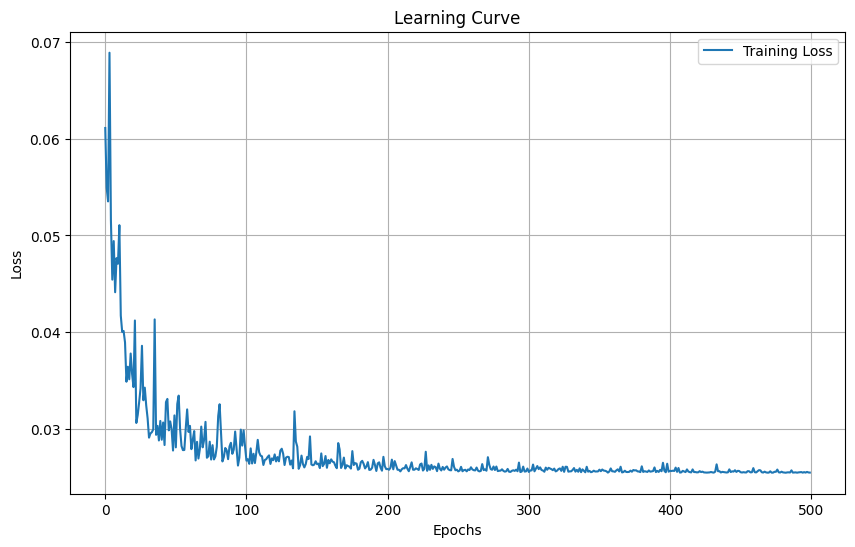

In [251]:
import matplotlib.pyplot as plt

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.show()
